# **Classification Model for Predicting Client Default Payment Status**

**`Created by:`**

Michael Nathaniel

---
## **1. Problem Identification**

**`Informasi Dataset:`**

Dataset yang digunakan berisikan data-data mengenai kredit klien yang membantu kita memahami dan memprediksi kemampuan klien membayar kredit pada bulan berikutnya.

**`SMART framework:`**

1. **Specific**: Membangun model klasifikasi untuk memprediksi status pembayaran kredit klien pada bulan berikutnya berdasarkan variabel-variabel seperti batas kredit, jenis kelamin, tingkat pendidikan, status pernikahan, usia, dan riwayat pembayaran sebelumnya.

2. **Measurable**: Menggunakan metrik evaluasi klasifikasi seperti akurasi, presisi, recall, dan F1-score untuk mengukur kinerja model.

3. **Achievable**: Menggunakan dataset dengan 2965 entri dan 24 kolom untuk melatih dan menguji model klasifikasi.

4. **Relevant**: Model ini relevan untuk memahami dan memprediksi kemampuan klien membayar kredit pada bulan berikutnya, memberikan wawasan yang berharga untuk manajemen risiko kredit.

5. **Time-Bound**: Menyelesaikan pengembangan model dan evaluasi kinerja dalam batas waktu yang ditentukan.

**`Problems:`** 

Buatlah model Classification untuk memprediksi `default_payment_next_month` menggunakan dataset yang sudah kalian simpan.

**`Objective:`**

Tujuan utama proyek ini adalah mengembangkan model klasifikasi yang dapat memprediksi dengan akurat status pembayaran kredit klien pada bulan berikutnya. Evaluasi kinerja model dengan metrik akurasi, presisi, recall, dan F1-score. Optimasi model menggunakan GridSearchCV. Implementasi model untuk prediksi pada data klien baru. Penyusunan laporan hasil evaluasi dan wawasan terkait faktor-faktor risiko kredit.

---
## **2. Query SQL**

Query yang telah dibuat untuk mengambil data dari Google Cloud Platform.

```SQL
SELECT 
    limit_balance,
    CAST(sex AS INT) AS sex,
    CAST(education_level AS INT) AS education_level,
    CAST(marital_status AS INT) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1, 
    pay_amt_2, 
    pay_amt_3, 
    pay_amt_4, 
    pay_amt_5, 
    pay_amt_6, 
    CAST(default_payment_next_month AS INT) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 18000;
```

---
## **3. Import Libraries**

In [307]:
# Melakukan import modul-modul yang akan digunakan pada project kali ini
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from feature_engine.outliers import Winsorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import pickle

---
## **4. Data Loading**

Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut.

Dataset yang digunakan pada project ini: `Classification-Model-for-Predicting-Client-Default-Payment-Status.csv`

### **4.1. Mengimport dataset file .csv menjadi Data Frame**

In [308]:
# Membuat Data Frame bernama data yang isinya diambil dari file .csv
data = pd.read_csv("Classification-Model-for-Predicting-Client-Default-Payment-Status.csv")

### **4.2. Menampilkan dataset**

In [309]:
# Code yang memungkinkan kita untuk menampilkan dataFrame tanpa colom yang terpotong karena limitasi ukuran secara default
pd.set_option('display.max_columns', None)

In [310]:
# Menampilkan 10 data teratas sebagai bentuk proses pemahaman data
data.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [311]:
# Menampilkan 10 data terbawah sebagai bentuk proses pemahaman data
data.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


### **4.3. Menduplikasi dataFrame 'data' dengan nama dataFrame baru yaitu 'data_duplicate'**

Untuk mengamankan dataFrame asli yang belum di modifikasi, kita akan melakukan duplikat terhadap Data Frame awal terlebih dahulu.

In [312]:
# Membuat duplikasi dari Data Frame data bernama data_duplicate
data_duplicate = data.copy()

### **4.4. Mengganti nama kolom**

Kita akan memperbaiki penamaan kolom 'pay_0' menjadi 'pay_1'

In [313]:
data.rename(columns={'pay_0': 'pay_1'}, inplace=True)

Kita bisa cek lagi dengan menampilkan kembali tabelnya

In [314]:
data.head()

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


### **4.5. Menggabungkan data education level 0 dan 6 menjadi 5**

Karena kedua edcuation level tersebut sama-sama mewakili data 'unknown', kita akan gabungkan data keduanya.

In [315]:
data['education_level'] = data['education_level'].replace(0, 5)
data['education_level'] = data['education_level'].replace(6, 5)

Masi kita cek kembali

In [316]:
data['education_level'].unique()

array([5, 4, 1, 2, 3], dtype=int64)

---
## **5. Exploratory Data Analysis (EDA)**

Bagian ini berisi explorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.

### **5.1. Melihat informasi mengenai Data Frame yang akan digunakan**

In [317]:
# Melihat informasi mengenai dataFrame yang akan digunakan
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_1                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Dari dataset yang kita miliki, kita temukan bahwa ada sebanyak `23 kolom` dengan `2,965 data entries`.

Keseluruhan tipe data mencakup numerical yang didominasi oleh float dan int.

Dataset ini mencakup limit_balance, sex, education_level, martial_status, age, pay_(0-6), bill_amt_(1-6), pay_amt_(1-6).

Dari keseluruhan data, tidak terlihat adanya kolom yang memiliki null values jika kita hanya lihat dari jumlah non-null count.

Kita akan memjadikan `kolom 'default_payment_next_mont' menjadi kolom utama` pada codingan kali ini.

### **5.2. Melihat deskripsi Data Frame yang akan digunakan**

Kita akan melihat deskripsi karakter dataset menggunakan method `.agg()`

Yang ingin kita lihat pada tahap ini adalah bagaimana `distribusi datanya, rata-rata, skewness, dll`.

Kita bisa melihat suatu data memiliki distribusi yang normal atau tidak dari beberapa cara seperti:
- Membandingkan mean dan median (`bila relatif sama, maka bisa diasumsikan bahwa distribusinya normal`)
- Melihat nilai skewness (`distribusi normal bila skewness diantara -0.5 hingga 0.5`)

In [318]:
# Menggunakan meethode .agg() untuk memprint deskripsi yang diperlukan.
# Tidak memakai .desc() agar lebih efisien dengan langsung memprint yang kita butuhkan.
describe_numeric = data.select_dtypes(include='number').agg(['count', 'skew', 'kurt', 'std', 'mean', 'median', 'min', 'max'])
describe_numeric

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
skew,1.000442,-0.441625,0.842110,-0.020106,0.772887,0.926790,0.861762,0.931460,1.101504,1.060173,0.978760,2.484598,2.458349,2.569937,2.448175,2.400343,2.432406,11.877647,2.940426e+01,8.044639,8.451541,11.468890,9.760184,1.394199
kurt,0.700329,-1.806186,1.326325,-1.345513,0.082963,4.173522,2.142303,2.598786,4.221387,4.195412,3.630528,8.117172,7.690538,8.752519,7.671313,7.214802,7.578229,192.777894,1.138308e+03,81.135750,89.310618,178.876905,143.311574,-0.056248
std,125030.415472,0.488333,0.774663,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,1.167305,72328.670541,70785.001588,68145.710745,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
mean,163369.308600,1.607757,1.851602,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,-0.254637,52118.305228,50649.153120,48239.757504,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
median,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24257.000000,23111.000000,21520.000000,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
min,10000.000000,1.000000,1.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-11545.000000,-67526.000000,-25443.000000,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,800000.000000,2.000000,5.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,7.000000,613860.000000,512650.000000,578971.000000,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


Dari hasil query syntax diatas, kita mendapat insight seperti:
- Ada `beberapa data yang memiliki distribusi data yang tidak normal` dengan variasi tinggi seperti data limit_balance, bill_amt_(1-6), pay_amt_(1-6)
- Namun, `ada juga data-data yang relatif normal distribusinya` seperti martial_status, pay_(0-6)

### **5.3. Melihat distribusi data berdasarkan status default payment**

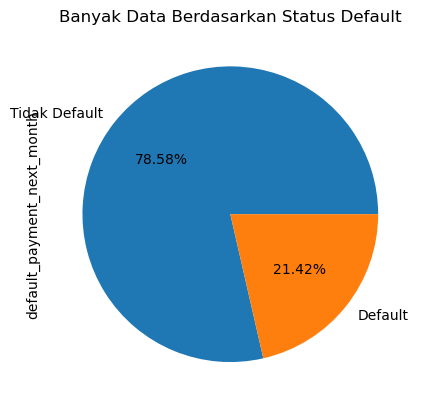

In [319]:
# Melakukan pembuatan plot untuk menampilkan pie chart yang menampilkan perbandingan data berdasarkan nama perushaan ('cab_type')
fig,ax1 = plt.subplots()

# Menghitung frekuensi masing-masing 'cab_type' menggunakan value_counts()
data['default_payment_next_month'].value_counts().plot(kind='pie', autopct='%.2f%%', labels=['Tidak Default', 'Default'], ax=ax1)

# Menambahkan judul pada pie chart
plt.title("Banyak Data Berdasarkan Status Default")

# Menampilkan pie chart
plt.show()

Dari keterangan yang diperoleh dari sumber dataset, kita mendapati bahwa `0 mewakili mereka yang tidak mengalami default payment (gagal bayar) dan 1 mewakili mereka yang berstatus default payment`.

Dari visualisasi diatas, kita ketahui bahwa `jumlah orang yang tidak mengalami default payment (tunggakan/ gagal bayar) lebih banyak` daripada mereka yang default yaitu `dengan perbandingannya adalah 78.58% : 21.42%`

### **5.4. 
**

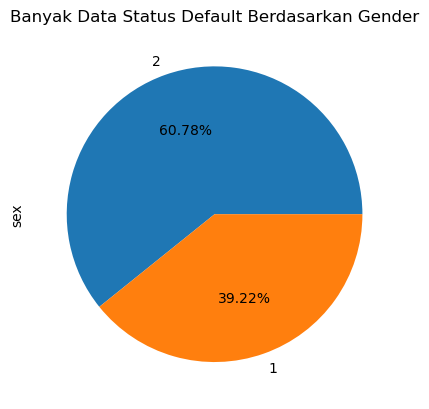

In [320]:
# Melakukan pembuatan plot untuk menampilkan pie chart yang menampilkan perbandingan data berdasarkan nama perushaan ('cab_type')
fig,ax1 = plt.subplots()

# Menghitung frekuensi masing-masing 'cab_type' menggunakan value_counts()
data['sex'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)

# Menambahkan judul pada pie chart
plt.title("Banyak Data Status Default Berdasarkan Gender")

# Menampilkan pie chart
plt.show()

Dari keterangan yang diperoleh dari sumber dataset, kita mendapati bahwa `1 mewakili pria dan 2 mewakili wanita`.

Dari visualisasi diatas, kita ketahui bahwa `yang lebih banyak mengalami default payment adalah gender wanita dibandingkan pria` yaitu dengan `perbandingan yaitu 60.78% : 39.22%`

### **5.5. Melihat distribusi data Jumlah Default dan Non-Default Payment Berdasarkan Education Level**

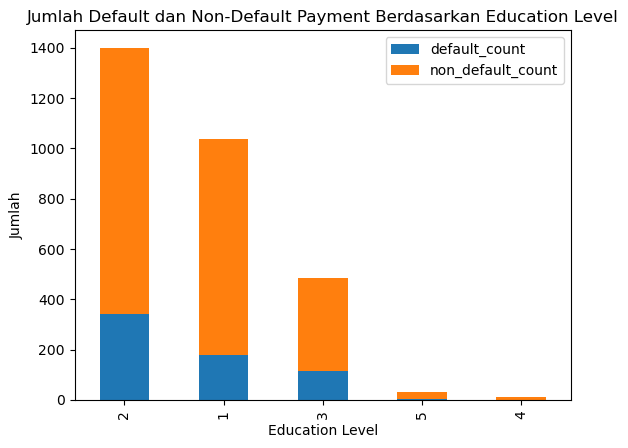

In [321]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah default dan non-default payment untuk setiap kategori 'education_level'
count_default = data[data['default_payment_next_month'] == 1]['education_level'].value_counts().reset_index(name='default_count')
count_non_default = data[data['default_payment_next_month'] == 0]['education_level'].value_counts().reset_index(name='non_default_count')

# Menggabungkan kedua DataFrame berdasarkan 'education_level', menggunakan merge outer untuk memastikan semua kategori terwakili
merged_data = pd.merge(count_default, count_non_default, on='index', how='outer').fillna(0)

# Membuat bar plot menggunakan seaborn untuk memvisualisasikan jumlah default dan non-default payment per kategori 'education_level'
ax = merged_data.plot(kind='bar', x='index', stacked=True)

# Menambahkan judul pada plot
plt.title("Jumlah Default dan Non-Default Payment Berdasarkan Education Level")
plt.xlabel("Education Level")
plt.ylabel("Jumlah")

# Menampilkan plot
plt.show()

Dari keterangan yang diperoleh dari sumber dataset, kita mendapati bahwa `1 mewakili graduate school (Tamatan S2 dan S3), 2 mewakili tamatan S1, 3 mewakili tamatan SMA, 4 mewakili others, 5 mewakili unknown`.

Dari visualisasi diatas, kita ketahui bahwa `anak kuliahan (S1) menjadi peminjam terbanyak disusul oleh Tamatan S2 dan S3 dan diurutan ketiga adalah tamatan SMA`.

### **5.3. Melihat distribusi data numerical**

Kita akan melihat distribusi data dari setiap data numerical menggunakan visualisasi berbentuk boxplot.

Dengan boxplot, kita bisa melihat secara kasar data apa saja yang memiliki ouliers.

##### **5.3.1. Melihat distribusi data limit_balance**

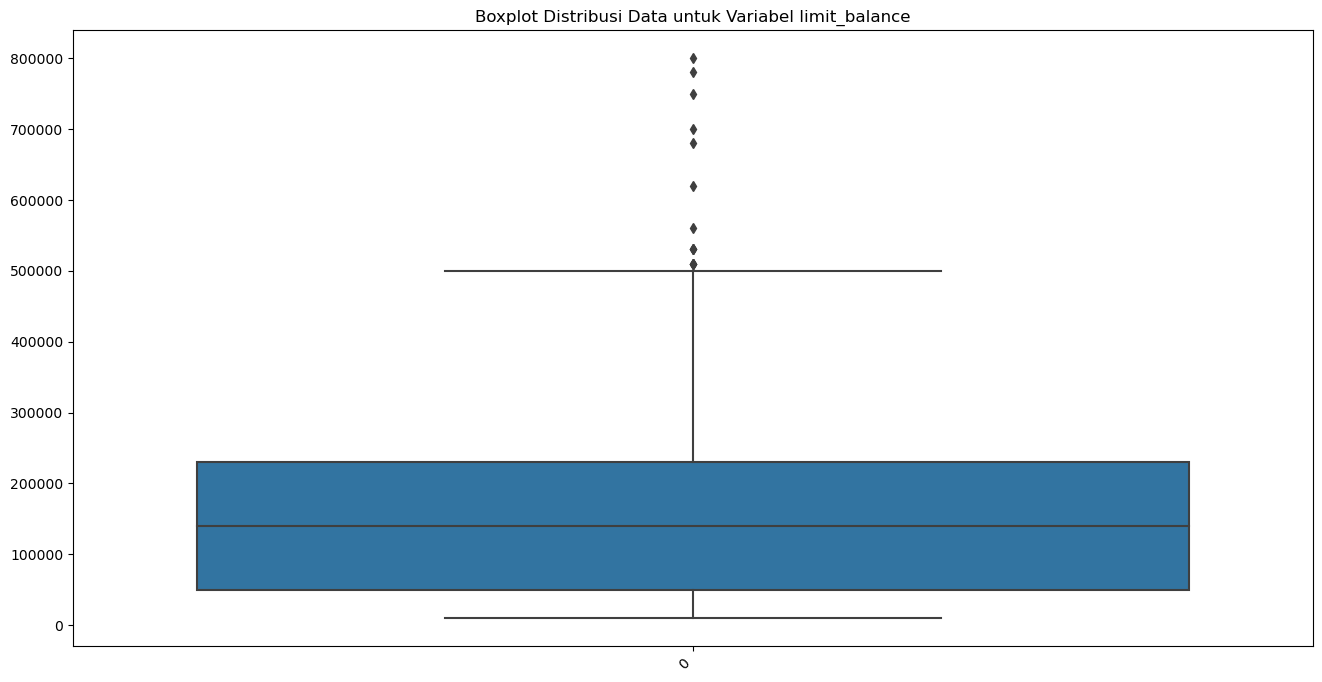

In [323]:
# Mengatur ukuran gambar
plt.figure(figsize=(16, 8))

# Membuat boxplot untuk setiap variabel numerik
sns.boxplot(data=data['limit_balance'])
plt.title('Boxplot Distribusi Data untuk Variabel limit_balance')
plt.xticks(rotation=45, ha='right')  # Memutar label sumbu x untuk lebih mudah dibaca
plt.show()

##### **5.3.2. Melihat distribusi data pay (1-6)**

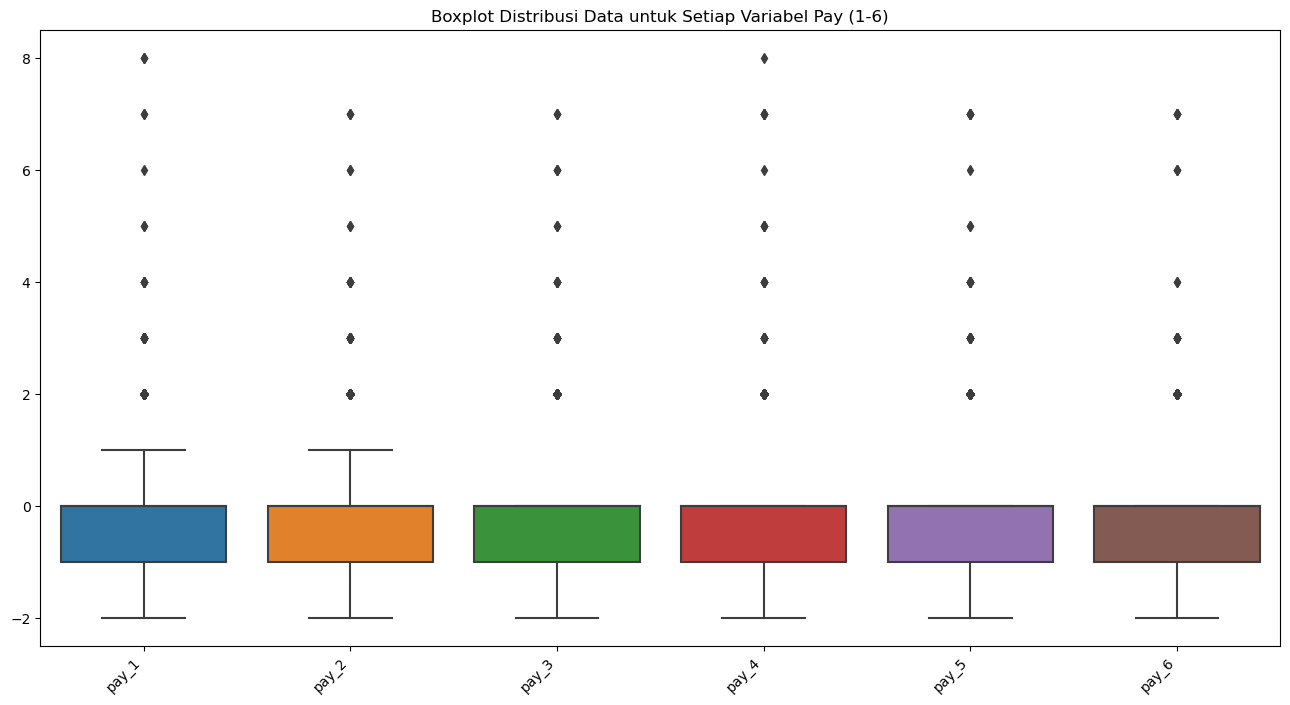

In [324]:
# Mengatur ukuran gambar
plt.figure(figsize=(16, 8))

# Membuat boxplot untuk setiap variabel numerik
sns.boxplot(data=data[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']])
plt.title('Boxplot Distribusi Data untuk Setiap Variabel Pay (1-6)')
plt.xticks(rotation=45, ha='right')  # Memutar label sumbu x untuk lebih mudah dibaca
plt.show()


##### **5.3.3. Melihat distribusi data bill_amt (1-6)**

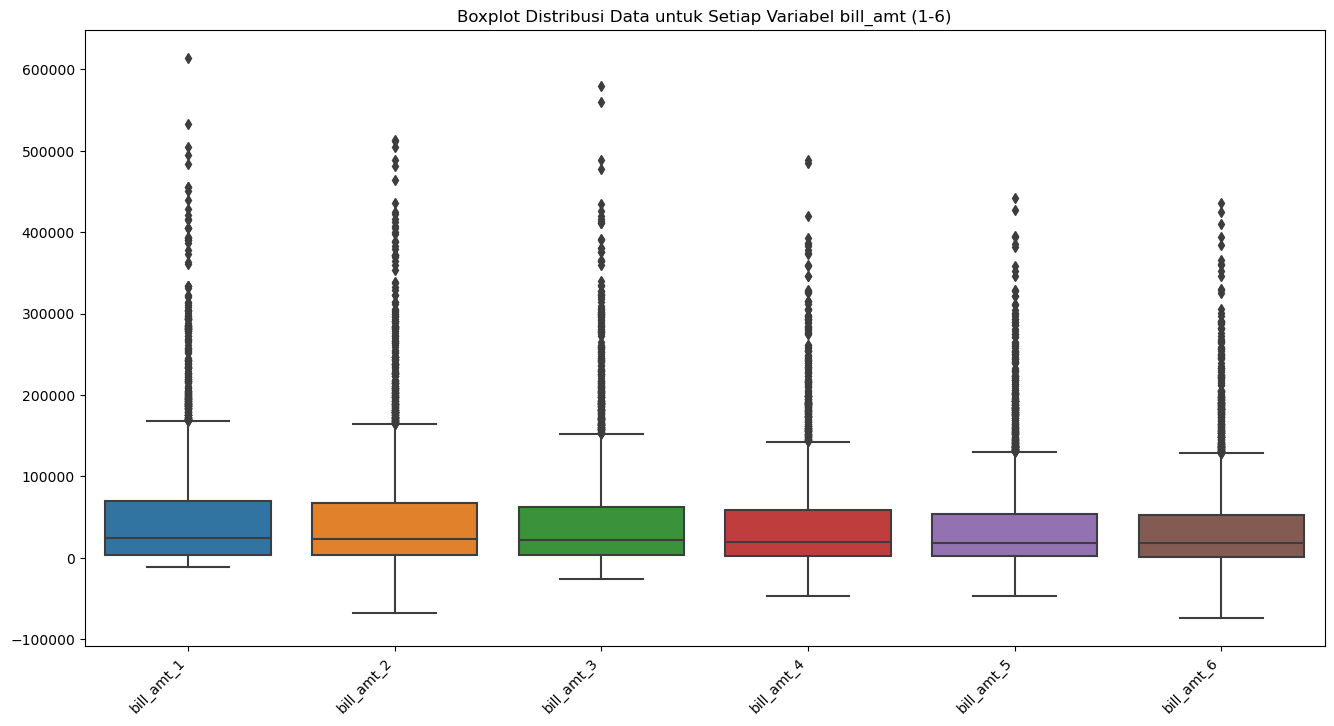

In [364]:
# Mengatur ukuran gambar
plt.figure(figsize=(16, 8))

# Membuat boxplot untuk setiap variabel numerik
sns.boxplot(data=data[['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6']])
plt.title('Boxplot Distribusi Data untuk Setiap Variabel bill_amt (1-6)')
plt.xticks(rotation=45, ha='right')  # Memutar label sumbu x untuk lebih mudah dibaca
plt.show()

##### **5.3.4. Melihat distribusi data pay_amt (1-6)**

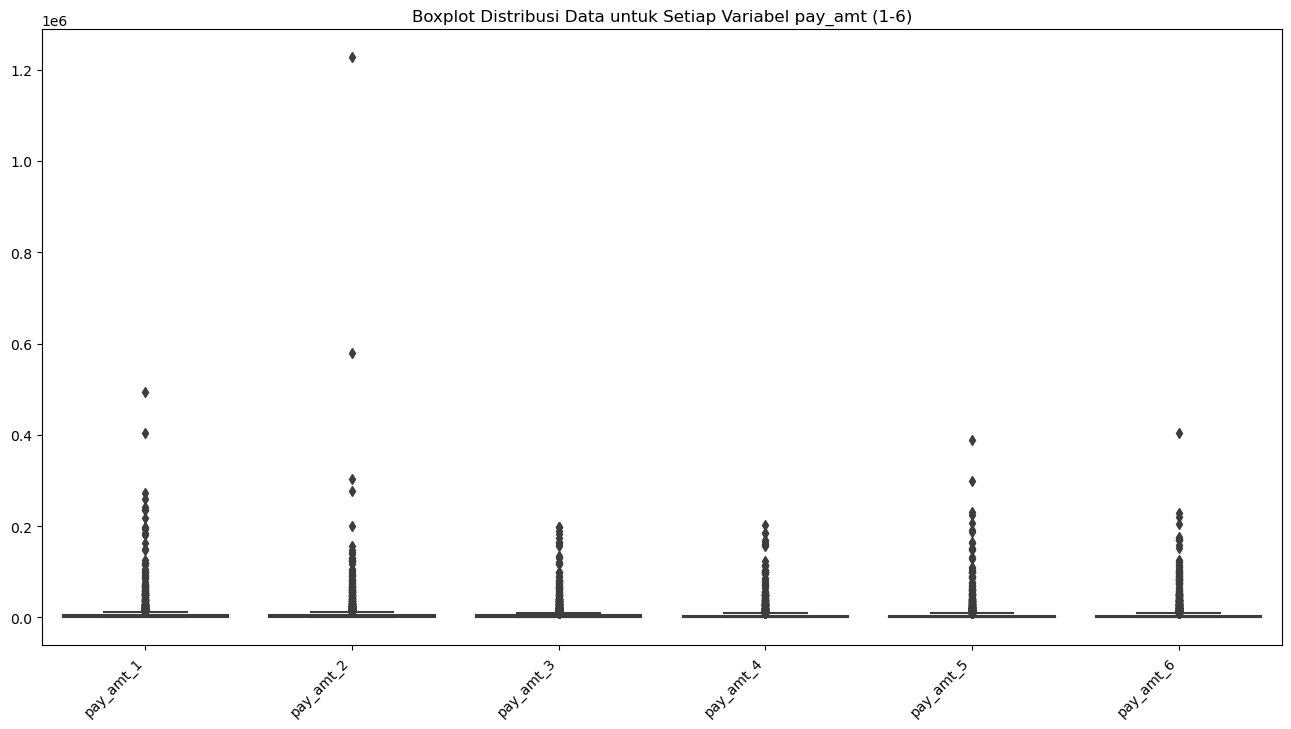

In [326]:
# Mengatur ukuran gambar
plt.figure(figsize=(16, 8))

# Membuat boxplot untuk setiap variabel numerik
sns.boxplot(data=data[['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']])
plt.title('Boxplot Distribusi Data untuk Setiap Variabel pay_amt (1-6)')
plt.xticks(rotation=45, ha='right')  # Memutar label sumbu x untuk lebih mudah dibaca
plt.show()

##### **5.3.5. Kesimpulan**

Dari visualisasi diatas, kita bisa lihat bahwa ada banyak outliers pada data-data yang berupa nominal biaya (finansial).

### **5.4. Melihat korelasi data-data waktu terhadap harga**

Untuk melakukan uji korelasi data dalam dataset terhadap `default_payment_next_mont`, kita bisa menggunakan metode uji korelasi seperti `metode kendall`.

Metode kendall digunakan karena ada data kita yang bersifat kategorial seperti sex, education_level, martial_status.

Berikut pengujiannya:

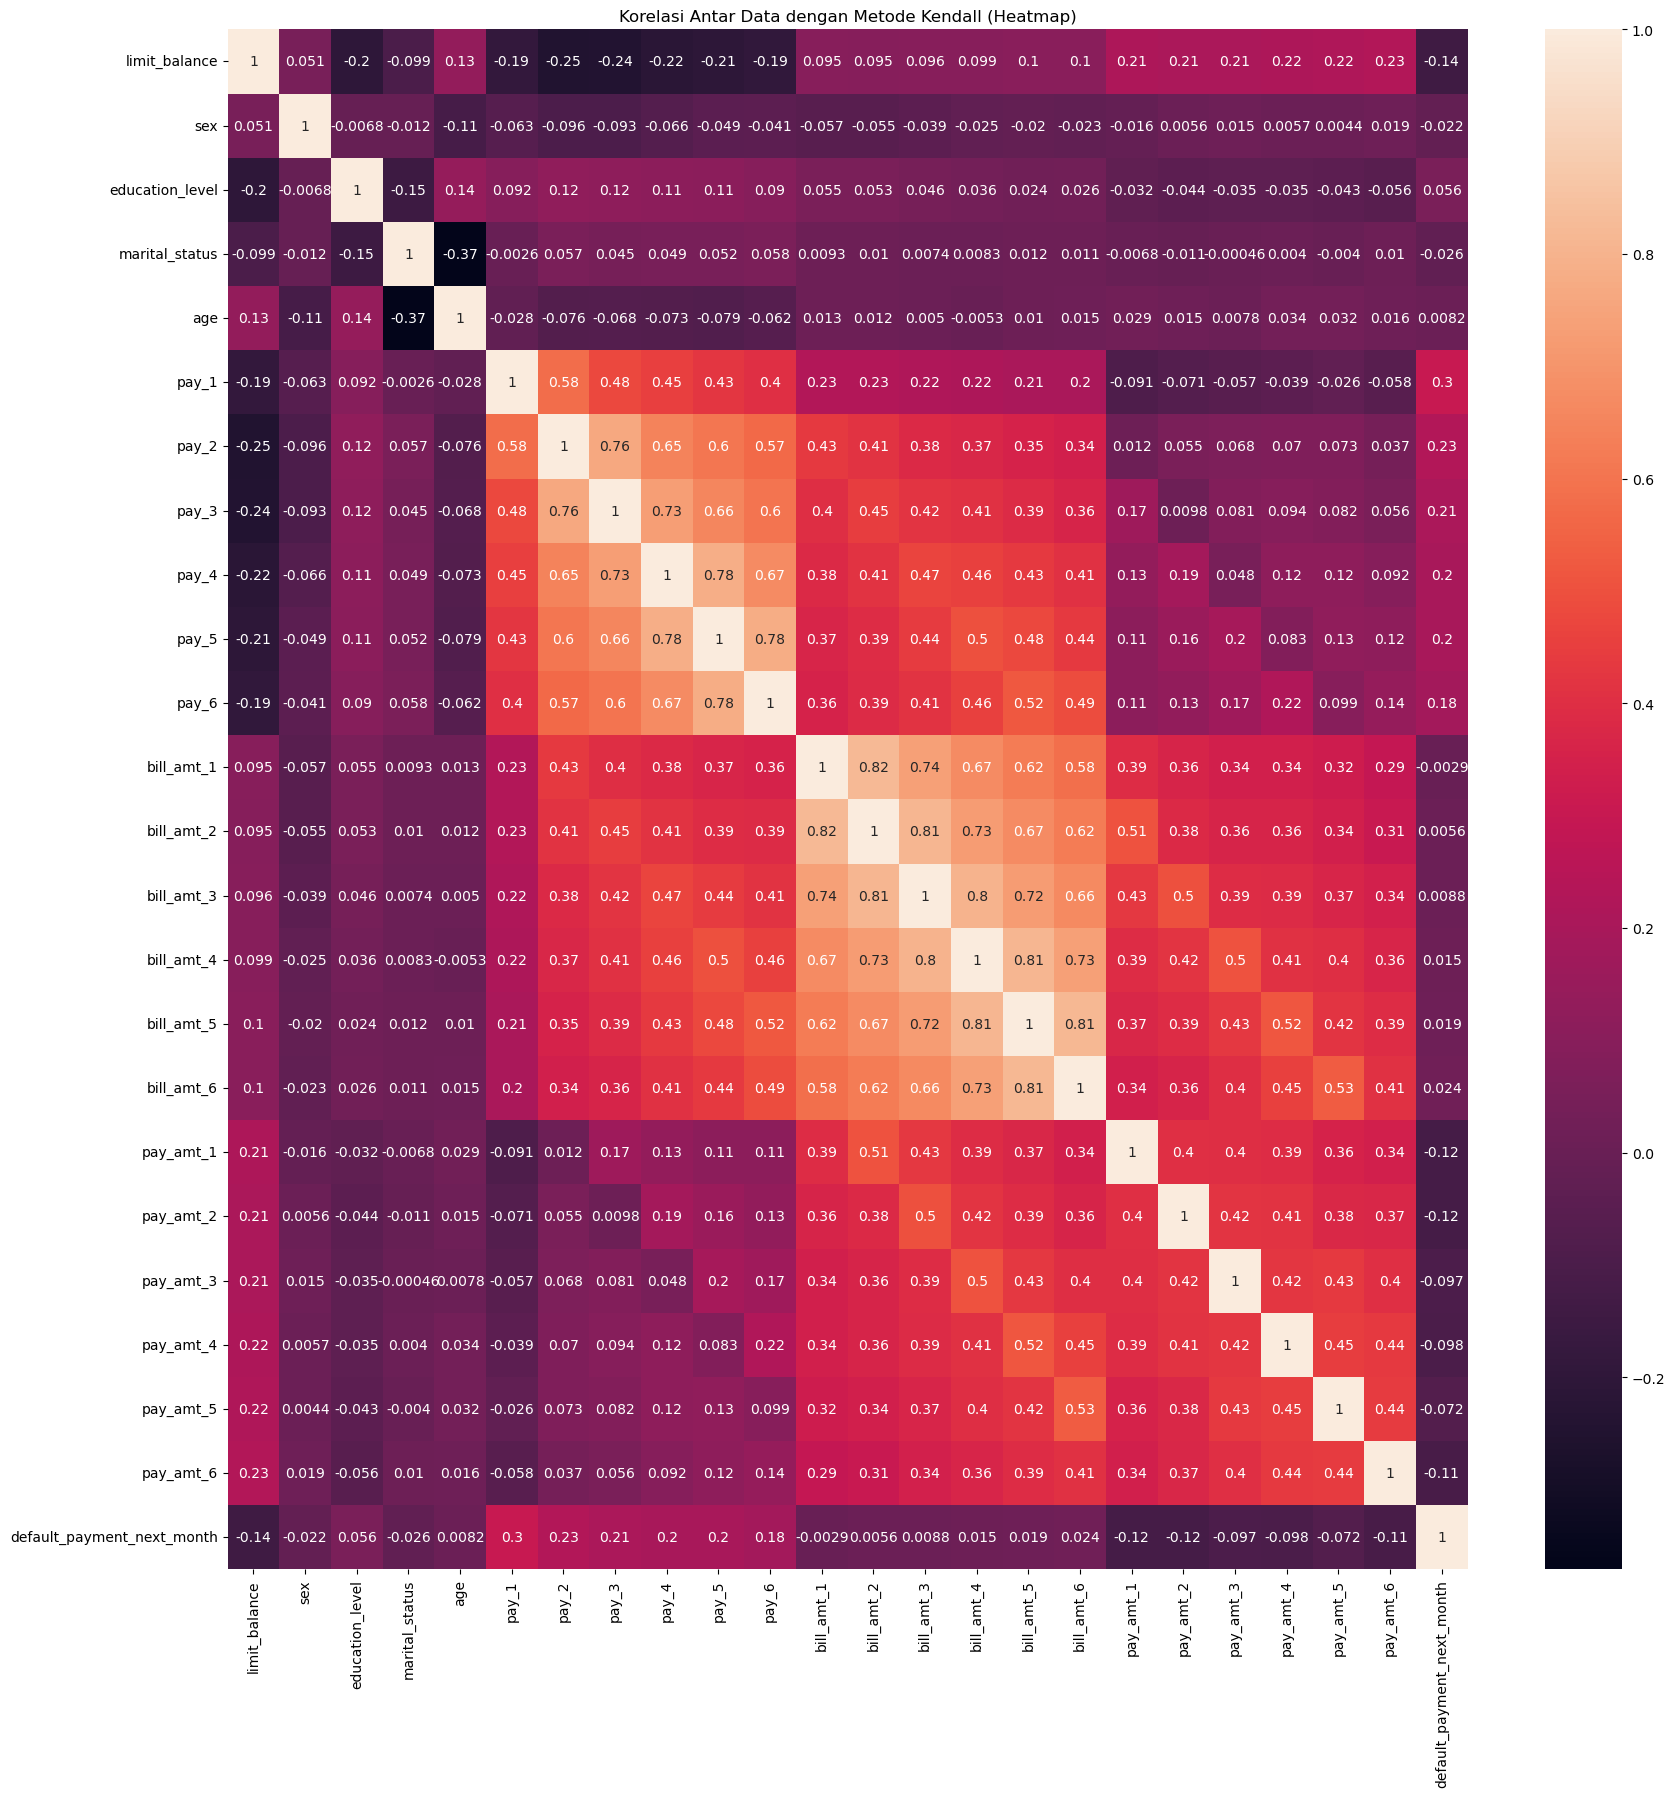

In [327]:
# Memilih kolom yang akan digunakan untuk analisis korelasi waktu dengan harga
data_waktu = data

# Membuat heatmap untuk memvisualisasikan korelasi
plt.figure(figsize=(20, 20))  # Menyesuaikan ukuran gambar
sns.heatmap(data_waktu.corr(method='kendall'), annot=True)

# Menambahkan judul
plt.title('Korelasi Antar Data dengan Metode Kendall (Heatmap)')

plt.show()

Dari hasil uji korelasi, kita bisa `melakukan pemilihan kolom tertentu yang akan kita gunakan untuk pembuatan model`.

In [328]:
data_2 = data[['limit_balance', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']]

Mesikpun data limit_balance, bill_amt, dan pay_amt memilki korelasi yang sangat rendah terhadap default_payment_next_month, kita akan `tetap memasukkannya karena berdasarkan domain knowldege, data-data tersebut berisikan data history terdahulu yang dapat mempengaruhi keputusan default tidaknya seseorang`.

### **5.5. Assumption 1 : No or Little Multicollinearity**

Multikolinearitas/ Multicollinearity adalah fenomena ketika sejumlah variabel independen berkorelasi kuat.

Untuk mengahsilkan model yang baik dan menghasilkan hasil prediksi yang maksimal, selain dari korelasi independe dengan dependen harus kuat, korelasi antar independen haruslah tidak ada atau hanya sedikit.

Hal ini penting karena kita akan mencari tahu variabel/ fitur apa yang mengakibatkan atau bertanggung jawab terhadap perubahan variabel dependen.

Sebelum kita memulai pengecekan, kita akan pisahkan datanya terlebih dahulu menjadi fitur (X) dan target (y).

In [329]:
# Splitting between `X` and `y`

# Memisahkan variabel independen (fitur) dan variabel dependen (target)
X = data_2.drop(['default_payment_next_month'], axis=1)
y = data_2['default_payment_next_month']

# Menampilkan variabel independen (fitur) `X`
X

,limit_balance,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0
2961,50000.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0
2962,450000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0
2963,50000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0


Setelah memisahkan menjadi dua data (fitur dan target), kita bisa membuat fungsi untuk menghitung VIF untuk sekelompok variabel independen.

In [330]:
# Buat fungsi untuk menghitung VIF untuk sekelompok variabel independen
def calc_vif(X):
    # Buat DataFrame kosong untuk menyimpan nama variabel dan nilai VIF-nya
    vif = pd.DataFrame()
    
    # Tambahkan kolom ke DataFrame untuk nama variabel
    vif["variabel"] = X.columns
    
    # Hitung nilai VIF untuk setiap variabel dan simpan dalam kolom 'VIF'
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Kembalikan DataFrame dengan nama variabel dan nilai VIF-nya
    return(vif)

Kita jalankan fungsi pengecakannya.

In [331]:
# Check Multicolinearity in X

calc_vif(X)

,variabel,VIF
0,limit_balance,2.564323
1,pay_1,1.875416
2,pay_2,3.251281
3,pay_3,3.521221
4,pay_4,4.191002
5,pay_5,4.988499
6,pay_6,3.357146
7,bill_amt_1,24.332769
8,bill_amt_2,39.846926
9,bill_amt_3,27.541679


Dari hasil analisis VIF menunjukkan adanya `multicollinearity dalam model regresi`.

Variabel seperti `bill_amt memiliki VIF tinggi, mengindikasikan hubungan kuat dengan variabel lain`.

Mesikpun terdapat banyak yang memiliki VIF tinggi, `kita tidak akan menghapus data ini karena berdasarkan domain knowldege, seluruh data ini mempengaruhi 'default_payment_next_mont'`.

### **5.5. Melihat nilai unique suatu kolom dengan low cardinality**

In [332]:
# Menggunakan method .nunique() untuk menghitung jumlah unique dari setiap kolom di dalam dataFrame.
data.nunique()

limit_balance                   59
sex                              2
education_level                  5
marital_status                   4
age                             49
pay_1                           11
pay_2                           10
pay_3                            9
pay_4                           10
pay_5                            9
pay_6                            8
bill_amt_1                    2643
bill_amt_2                    2592
bill_amt_3                    2549
bill_amt_4                    2504
bill_amt_5                    2482
bill_amt_6                    2461
pay_amt_1                     1415
pay_amt_2                     1372
pay_amt_3                     1302
pay_amt_4                     1214
pay_amt_5                     1194
pay_amt_6                     1189
default_payment_next_month       2
dtype: int64

In [333]:
data['sex'].unique()

array([1, 2], dtype=int64)

In [334]:
data['education_level'].unique()

array([5, 4, 1, 2, 3], dtype=int64)

In [335]:
data['marital_status'].unique()

array([1, 2, 3, 0], dtype=int64)

---
## **6. Feature Engineering**

Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

### **6.1. Melihat banyak kemunculan suatu value**

In [336]:
# Menggunakan fungsi value_counts() untuk menghitung jumlah kemunculan setiap nilai unik
# dalam kolom "default_payment_next_month" pada dataset 'data'.
data_2.default_payment_next_month.value_counts()

0    2330
1     635
Name: default_payment_next_month, dtype: int64

Kita ketahui dari keseluruhan data yang akan kita gunakan, ada 2330 orang yang tergolong bisa membayar dan 635 orang yang tergolong default payment (gagal bayar)

### **6.2. Feature Data Splitting**

##### **6.2.1. Split menjadi X (features) and y (target)**

Untuk membuat model machine learning, kita perlu membagi data menjadi dua bagian yaitu yang ingin kita prediksi/ target (y) dan yang untuk memprediksi/ fitur (X)

In [337]:
# Splitting between X and y

# Memisahkan variabel independen (fitur) dan variabel dependen (target)
X = data_2.drop(['default_payment_next_month'], axis=1)
y = data_2['default_payment_next_month']

In [338]:
# Menampilkan variabel independen (fitur) X
X

,limit_balance,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0
2961,50000.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0
2962,450000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0
2963,50000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0


In [339]:
# Menampilkan variabel dependen (target) y
y

0       1
1       0
2       1
3       0
4       0
       ..
2960    0
2961    1
2962    1
2963    0
2964    0
Name: default_payment_next_month, Length: 2965, dtype: int64

##### **6.2.2. Split between Train-Set and Test-Set**

Kemudian setelah dipisah menjadi fitur (X) dan target (y), kita akan memisahkan kembali masing-masingnya menjadi data train (digunakan oleh model untuk belajar) dan data test (digunakan oleh model sebagai data uji/ test)

In [340]:
# Splitting between train and test

# Memisahkan data menjadi set pelatihan (train) dan set pengujian (test)
# Dengan rasio 80:20 dan seed (random_state) 46 untuk hasil yang dapat direproduksi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)

# Menampilkan bentuk (shape) dari set pelatihan dan set pengujian
print('X-train', X_train.shape)
print('X-Test', X_test.shape)

X-train (2372, 19)
X-Test (593, 19)


### **6.3. Handling Outliers**

In [341]:
# Menyediakan daftar kolom yang akan dihandle untuk outliers
data_kolom_handling_outliers = ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

# Menggunakan Winsorizer dengan parameter tertentu
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=data_kolom_handling_outliers)

# Melatih Winsorizer menggunakan data latihan (X_train)
winsorizer.fit(X_train)

# Mengaplikasikan transformasi Winsorizer ke dalam dataset latihan (X_train)
X_train = winsorizer.transform(X_train)

### **6.4. Feature Scaling**

Data scaling adalah proses mengubah rentang nilai data agar dapat memiliki skala yang seragam.

Dalam Python, contoh metode yang sering digunakan adalah Min-Max Scaling atau Z-score Scaling untuk melakukan hal ini.

Dalam kasus kali ini, karena datanya memiliki distribusi yang tidak rata, maka kita akan menggunakan metode Robust Scaler.

Robust Scaler bekerja dengan cara mengubah nilai-nilai data menggunakan median dan interquartile range (IQR) alih-alih menggunakan mean dan standard deviation seperti pada Z-score Scaling.

Kita akan melakukan Robust Scaler terhadap data numerical yaitu distance.

In [342]:
# Menyiapkan daftar kolom yang akan dihandle untuk proses scaling
data_kolom_handling_scaling = ["limit_balance", "bill_amt_1", "bill_amt_2", "bill_amt_3", 
                               "bill_amt_4", "bill_amt_5", "bill_amt_6", "pay_amt_1", 
                               "pay_amt_2", "pay_amt_3", "pay_amt_4", "pay_amt_5", "pay_amt_6"]

# Membuat preprocessor dengan menggunakan make_column_transformer
# Kolom-kolom dalam data_kolom_handling_scaling akan diubah menggunakan RobustScaler
# remainder="passthrough" mengizinkan kolom lainnya untuk tetap tidak berubah
preprocessor = make_column_transformer((RobustScaler(), data_kolom_handling_scaling), remainder="passthrough")

Kita tidak melakukan handling terhadap kolom pay (1-6) karena tidak terdapat outliers extreme.

---
## **7. Model Definition**

Pada tahap ini, kita akan melakukan pendefinisian model

Karena kita akan melakukan prediksi klasifikasi, kita akan mencoba menggunakan 3 model yaitu Logistic Regression, SVM, dan KNN.

Kita akan langsung menggunakan pipeline untuk memudahkan kita.

### **7.1. Logistic Regression Pipeline**

In [343]:
# Membuat pipeline dengan dua langkah: preprocessing dan Logistic Regression
logreg_pipeline = make_pipeline(preprocessor, LogisticRegression(random_state=42, n_jobs=-1, max_iter=5000))

# Menampilkan langkah-langkah dalam pipeline
print('Pipeline steps : ', logreg_pipeline.steps)

Pipeline steps :  [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 ['limit_balance', 'bill_amt_1', 'bill_amt_2',
                                  'bill_amt_3', 'bill_amt_4', 'bill_amt_5',
                                  'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                                  'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
                                  'pay_amt_6'])])), ('logisticregression', LogisticRegression(max_iter=5000, n_jobs=-1, random_state=42))]


### **7.2. SVM Pipeline**

In [344]:
# Membuat pipeline dengan dua langkah: preprocessing dan Support Vector Machine (SVM)
svm_pipeline = make_pipeline(preprocessor, SVC(random_state=42))

# Menampilkan langkah-langkah dalam pipeline
print('Pipeline steps : ', svm_pipeline.steps)

Pipeline steps :  [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 ['limit_balance', 'bill_amt_1', 'bill_amt_2',
                                  'bill_amt_3', 'bill_amt_4', 'bill_amt_5',
                                  'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                                  'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
                                  'pay_amt_6'])])), ('svc', SVC(random_state=42))]


### **7.3. KNN Pipeline**

In [345]:
# Membuat pipeline dengan dua langkah: preprocessing dan K-Nearest Neighbors (KNN)
knn_pipeline = make_pipeline(preprocessor, KNeighborsClassifier(n_jobs=-1))

# Menampilkan langkah-langkah dalam pipeline
print('Pipeline steps : ', knn_pipeline.steps)

Pipeline steps :  [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 ['limit_balance', 'bill_amt_1', 'bill_amt_2',
                                  'bill_amt_3', 'bill_amt_4', 'bill_amt_5',
                                  'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                                  'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
                                  'pay_amt_6'])])), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))]


---
## **8. Model Training**

Pada tahap ini kita akan melakukan model training untuk model-model yang telah kita pilih.

### **8.1. Logistic Regression Pipeline Training**

In [346]:
# Melibatkan model training pada pipeline Logistic Regression
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=5000, n_jobs=-1,
                                    random_state=42))])

### **8.2. SVM Pipeline Training**

In [347]:
# Melibatkan model training pada pipeline Support Vector Machine (SVM)
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('svc', SVC(random_state=42))])

### **8.3. KNN Pipeline Training**

In [348]:
# Melibatkan model training pada pipeline K-Nearest Neighbors (KNN)
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

---
## **9. Model Evaluation**

Pada tahap ini, kita akan melakukan evaluasi terhadap model yang akan kita gunakan.

Kita bisa gunakan Classification Report yang terdiri dari:
1. **Accuracy**:

    Mengukur sejauh mana model klasifikasi benar dalam memprediksi seluruh kelas. Digunakan ketika keseimbangan antara kelas positif dan negatif cukup merata.
2. **Precision**:

    Menunjukkan seberapa banyak dari prediksi positif yang benar. Berguna ketika fokus pada mengurangi false positive.
3. **Recall (Sensitivitas)**:

    Menunjukkan seberapa banyak dari kelas positif yang terdeteksi dengan benar. Berguna ketika fokus pada mengurangi false negative.
4. **F1 Score**:

    Menggabungkan precision dan recall untuk memberikan indikasi keseluruhan kinerja model. Cocok digunakan ketika terdapat trade-off antara precision dan recall.

Kita akan berfokus pada keakuratan memprediksi nilai 1 (yang tergolong default payment/ gagal bayar)

Kita akan membaca Recall karena kita ingin mengurangi False Negatif.

Positif dalam kasus ini adalah merka yang positif default payment.

Tentu kita tidak ingin ada salah prediksi karena dapat memberikan kerugian.

### **9.1. Pipeline Base Model Eval**

##### **9.1.1. Logistic Regression Pipeline Base Model Eval**

F1 Score - Train Set  :  0.42372881355932207 

Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      1864
           1       0.75      0.30      0.42       508

    accuracy                           0.83      2372
   macro avg       0.79      0.63      0.66      2372
weighted avg       0.82      0.83      0.80      2372
 

Confusion Matrix      : 


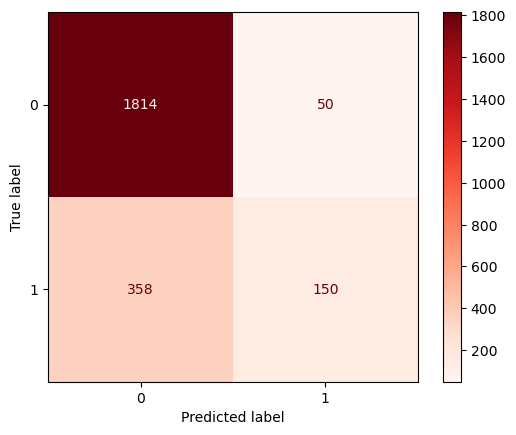

In [349]:
# Check Performance Model against Train-Set

# Melakukan prediksi pada dataset pelatihan menggunakan model Logistic Regression
logreg_pipeline_predict_train = logreg_pipeline.predict(X_train)

# Menampilkan F1 Score pada dataset pelatihan
print('F1 Score - Train Set  : ', f1_score(y_train, logreg_pipeline_predict_train), '\n')

# Menampilkan Classification Report pada dataset pelatihan
print('Classification Report : \n', classification_report(y_train, logreg_pipeline_predict_train), '\n')

# Menampilkan Confusion Matrix pada dataset pelatihan
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_train, y_train, cmap='Reds'))

F1 Score - Test Set  :  0.37158469945355194 

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89       466
           1       0.61      0.27      0.37       127

    accuracy                           0.81       593
   macro avg       0.72      0.61      0.63       593
weighted avg       0.78      0.81      0.78       593
 

Confusion Matrix      : 


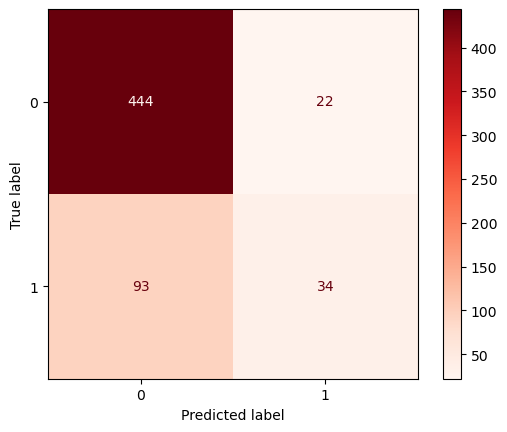

In [350]:
# Check Performance Model against Test-Set

# Melakukan prediksi pada dataset uji menggunakan model Logistic Regression
logreg_pipeline_predict_test = logreg_pipeline.predict(X_test)

# Menampilkan F1 Score pada dataset uji
print('F1 Score - Test Set  : ', f1_score(y_test, logreg_pipeline_predict_test), '\n')

# Menampilkan Classification Report pada dataset uji
print('Classification Report : \n', classification_report(y_test, logreg_pipeline_predict_test), '\n')

# Menampilkan Confusion Matrix pada dataset uji
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_test, y_test, cmap='Reds'))

Dari hasil model evaluation, kita temukan bahwa untuk nilai 1 model Logistic Regression:
- Selisih recall Train-Set dengan Test-Set adalah 0.3
- Selisih F1 Score Train-Set dengan Test-Set adalah 0.5
- Terjadi Overfitting (Train lebih baik)

##### **9.1.2. SVM Pipeline Base Model Evaluation**

F1 Score - Train Set  :  0.5494223363286265 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1864
           1       0.79      0.42      0.55       508

    accuracy                           0.85      2372
   macro avg       0.82      0.70      0.73      2372
weighted avg       0.84      0.85      0.83      2372
 



Confusion Matrix      : 


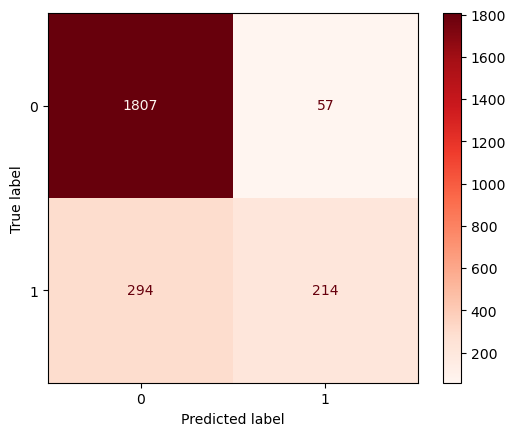

In [351]:
# Check Performance Model against Train-Set

# Melakukan prediksi pada dataset pelatihan menggunakan model Support Vector Machine (SVM)
svm_pipeline_predict_train = svm_pipeline.predict(X_train)

# Menampilkan F1 Score pada dataset pelatihan
print('F1 Score - Train Set  : ', f1_score(y_train, svm_pipeline_predict_train), '\n')

# Menampilkan Classification Report pada dataset pelatihan
print('Classification Report : \n', classification_report(y_train, svm_pipeline_predict_train), '\n')

# Menampilkan Confusion Matrix pada dataset pelatihan
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(svm_pipeline, X_train, y_train, cmap='Reds'))


F1 Score - Test Set  :  0.42780748663101603 

Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.96      0.89       466
           1       0.67      0.31      0.43       127

    accuracy                           0.82       593
   macro avg       0.75      0.64      0.66       593
weighted avg       0.80      0.82      0.79       593
 

Confusion Matrix      : 


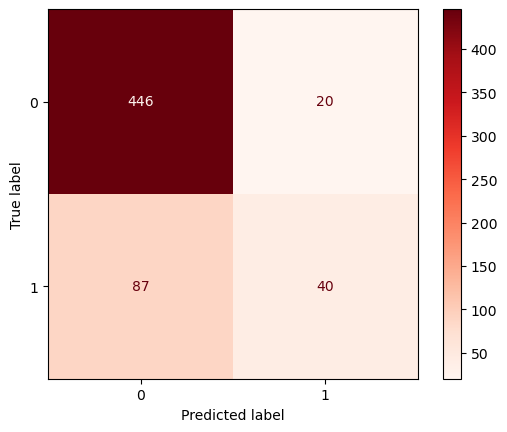

In [352]:
# Check Performance Model against Test-Set

# Melakukan prediksi pada dataset uji menggunakan model Support Vector Machine (SVM)
svm_pipeline_predict_test = svm_pipeline.predict(X_test)

# Menampilkan F1 Score pada dataset uji
print('F1 Score - Test Set  : ', f1_score(y_test, svm_pipeline_predict_test), '\n')

# Menampilkan Classification Report pada dataset uji
print('Classification Report : \n', classification_report(y_test, svm_pipeline_predict_test), '\n')

# Menampilkan Confusion Matrix pada dataset uji
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(svm_pipeline, X_test, y_test, cmap='Reds'))

Dari hasil model evaluation, kita temukan bahwa untuk nilai 1 model SVM:
- Selisih recall Train-Set dengan Test-Set adalah 0.11
- Selisih F1 Score Train-Set dengan Test-Set adalah 0.12
- Terjadi Overfitting (Train lebih baik)

##### **9.1.3. KNN Pipeline Base Model Evaluation**

F1 Score - Train Set  :  0.607565011820331 

Classification Report : 
               precision    recall  f1-score   support

           0       0.88      0.96      0.91      1864
           1       0.76      0.51      0.61       508

    accuracy                           0.86      2372
   macro avg       0.82      0.73      0.76      2372
weighted avg       0.85      0.86      0.85      2372
 

Confusion Matrix      : 


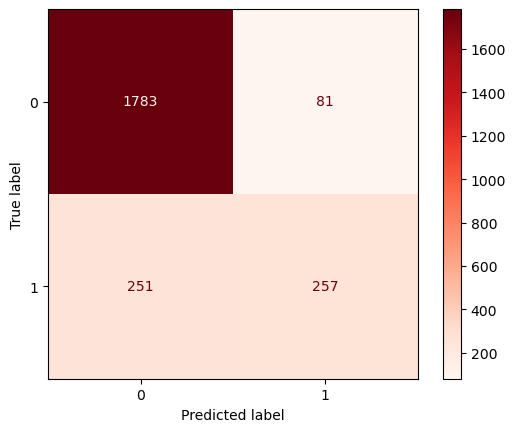

In [353]:
# Check Performance Model against Train-Set

# Melakukan prediksi pada dataset pelatihan menggunakan model K-Nearest Neighbors (KNN)
knn_pipeline_predict_train = knn_pipeline.predict(X_train)

# Menampilkan F1 Score pada dataset pelatihan
print('F1 Score - Train Set  : ', f1_score(y_train, knn_pipeline_predict_train), '\n')

# Menampilkan Classification Report pada dataset pelatihan
print('Classification Report : \n', classification_report(y_train, knn_pipeline_predict_train), '\n')

# Menampilkan Confusion Matrix pada dataset pelatihan
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_pipeline, X_train, y_train, cmap='Reds'))

F1 Score - Test Set  :  0.392156862745098 

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       466
           1       0.52      0.31      0.39       127

    accuracy                           0.79       593
   macro avg       0.68      0.62      0.63       593
weighted avg       0.76      0.79      0.77       593
 

Confusion Matrix      : 


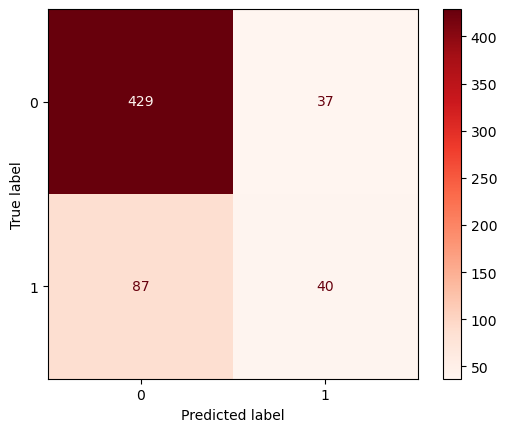

In [354]:
# Check Performance Model against Test-Set

# Melakukan prediksi pada dataset uji menggunakan model K-Nearest Neighbors (KNN)
knn_pipeline_predict_test = knn_pipeline.predict(X_test)

# Menampilkan F1 Score pada dataset uji
print('F1 Score - Test Set  : ', f1_score(y_test, knn_pipeline_predict_test), '\n')

# Menampilkan Classification Report pada dataset uji
print('Classification Report : \n', classification_report(y_test, knn_pipeline_predict_test), '\n')

# Menampilkan Confusion Matrix pada dataset uji
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_pipeline, X_test, y_test, cmap='Reds'))

Dari hasil model evaluation, kita temukan bahwa untuk nilai 1 model KNN:
- Selisih recall Train-Set dengan Test-Set adalah 0.20
- Selisih F1 Score Train-Set dengan Test-Set adalah 0.22
- Terjadi Overfitting (Train lebih baik)

##### **9.1.4. Kesimpulan Pipeline Base Model Evaluation**

Dari hasil keseluruhan Base Model Evaluation, `kita akan menggunakan Logisitc Regression dimana Overfitting yang terjadi tidak terlalu besar dibanding model SVM dan KNN`.

Selain itu, intepretasi Logistic Regression jauh lebih mudah dibandingan dua model lainnya.

### **9.2. Hyperparameter Tuning**

Hyperparameter tuning adalah proses mengoptimalkan nilai-nilai yang ditentukan sebelumnya (hyperparameter) pada model machine learning untuk mencapai performa yang lebih baik.

Hyperparameter adalah parameter yang tidak dapat dipelajari oleh model selama pelatihan, dan memilih nilai yang tepat untuk hyperparameter dapat menghasilkan model yang lebih akurat dan efisien.

Dengan melakukan hyperparameter tuning, kita dapat meningkatkan kemampuan model untuk melakukan prediksi dengan lebih baik, mengurangi overfitting atau underfitting, dan meningkatkan kinerja secara keseluruhan.

Berikut kita akan memulai dengan mendefinisikan hyperparameter.

Kita akan menggunakan Grid Search Cross Validation karena menjamin eksplorasi menyeluruh dari ruang hyperparameter.

In [355]:
# Mendefinisikan hyperparameter untuk GridSearchCV
grid_search_params = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                      'logisticregression__penalty': ['elasticnet'],
                      'logisticregression__class_weight': ['balanced'],
                      'logisticregression__solver': ['saga'],
                      'logisticregression__l1_ratio': [0, 0.5, 1]}

# Membuat objek GridSearchCV dengan model Logistic Regression dan parameter grid yang telah ditentukan
clf_grid = GridSearchCV(logreg_pipeline, param_grid=grid_search_params, cv=5)

# Melakukan pencarian parameter terbaik menggunakan dataset pelatihan
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         ['limit_balance',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                                          'bill_amt_3',
                                                                          'bill_amt_4',
                                                                          'bill_amt_5',
                                                                          'bill_amt_6',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_amt_5',
                                                                          'pay_amt_6'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=5000,
                                                           n_jobs=-1,
                                                           random_state=42))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logisticregression__class_weight': ['balanced'],
                         'logisticregression__l1_ratio': [0, 0.5, 1],
                         'logisticregression__penalty': ['elasticnet'],
                         'logisticregression__solver': ['saga']})

Setelah kita tentukan Parameter beserta opsi setiap parameter, kita cari opsi terbaik dari masing-masing parameter.

In [356]:
# Mendapatkan parameter terbaik dari hasil GridSearchCV
best_params = clf_grid.best_params_

# Menampilkan parameter terbaik
best_params

{'logisticregression__C': 0.01,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__l1_ratio': 1,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__solver': 'saga'}

Kemudia kita akan buat pipeline baru berdasarkan parameter terbaik.

In [357]:
# Bikin Pipeline baru dengan parameter terbaik dari hasil GridSearch

# Mendapatkan model terbaik dari hasil GridSearchCV
best_estimator = clf_grid.best_estimator_

# Menampilkan model terbaik
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=1,
                                    max_iter=5000, n_jobs=-1,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [358]:
# Mendapatkan langkah (step) khusus dalam pipeline yang merupakan model Logistic Regression
best_estimator.named_steps['logisticregression']

LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=1, max_iter=5000,
                   n_jobs=-1, penalty='elasticnet', random_state=42,
                   solver='saga')

In [359]:
# Mendapatkan koefisien dari model Logistic Regression
print('Coefficient : ', best_estimator.named_steps['logisticregression'].coef_)

# Mendapatkan intercept dari model Logistic Regression
print('Intercept   : ', best_estimator.named_steps['logisticregression'].intercept_)

Coefficient :  [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.0980375   0.         -0.00683435  0.
  -0.00354079  0.4103971   0.04764605  0.09225477  0.          0.07273045
   0.01821038]]
Intercept   :  [-0.08345099]


Intercept dari model ini adalah -0.08345099 yang menjadi nilai awal default payment jiak variabel lainnya 0. Melihat dari hasil coefficientnya, kita peroleh bahwa tidak semua variabel yang digunakan pada model ini memberikan dampak terhadap target (default_payment_next_month).

F1 Score - Train Set  :  0.5404411764705882 

Classification Report : 
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      1864
           1       0.51      0.58      0.54       508

    accuracy                           0.79      2372
   macro avg       0.69      0.71      0.70      2372
weighted avg       0.80      0.79      0.79      2372
 

Confusion Matrix      : 


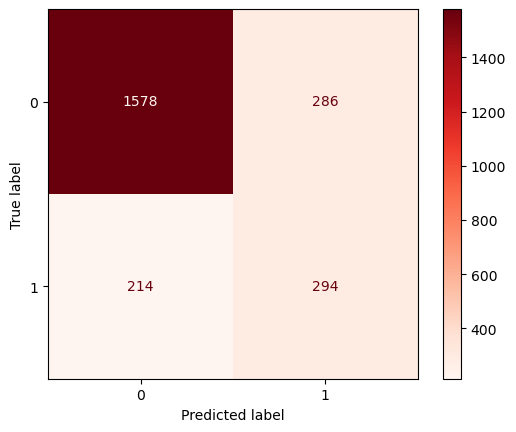

In [360]:
# Check Performance Model against Train-Set

# Melakukan prediksi pada dataset pelatihan menggunakan model terbaik
best_estimator_predict_train = best_estimator.predict(X_train)

# Menampilkan F1 Score pada dataset pelatihan
print('F1 Score - Train Set  : ', f1_score(y_train, best_estimator_predict_train), '\n')

# Menampilkan Classification Report pada dataset pelatihan
print('Classification Report : \n', classification_report(y_train, best_estimator_predict_train), '\n')

# Menampilkan Confusion Matrix pada dataset pelatihan
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_train, y_train, cmap='Reds'))

F1 Score - Test Set  :  0.5267175572519085 

Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       466
           1       0.51      0.54      0.53       127

    accuracy                           0.79       593
   macro avg       0.69      0.70      0.70       593
weighted avg       0.80      0.79      0.79       593
 

Confusion Matrix      : 


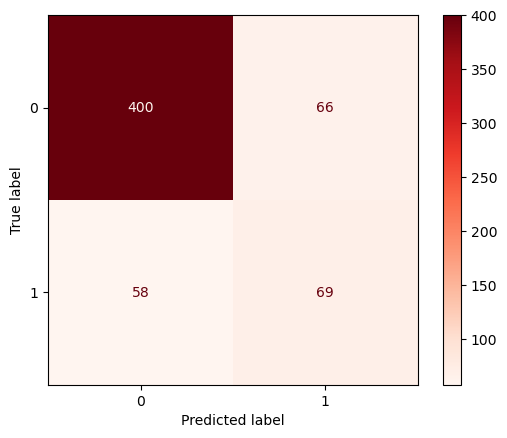

In [361]:
# Check Performance Model against Test-Set

# Melakukan prediksi pada dataset uji menggunakan model terbaik
best_estimator_predict_test = best_estimator.predict(X_test)

# Menampilkan F1 Score pada dataset uji
print('F1 Score - Test Set  : ', f1_score(y_test, best_estimator_predict_test), '\n')

# Menampilkan Classification Report pada dataset uji
print('Classification Report : \n', classification_report(y_test, best_estimator_predict_test), '\n')

# Menampilkan Confusion Matrix pada dataset uji
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='Reds'))

Dari melakukan Hyperparameter Tuning terhadap model Logistic Regression yang sebelumnya telah kita lakukan, kita memperoleh hasil yang lebih baik dari model dasar sebelumya, seperti:
- Dari yang sebelumnya Overfitting menjadi Fit (beda hanya 0.1)
- Recall dan F1 Score mengalami peningkatan dimana keduanya semkain mendakati 1 yaitu diatas 0.50

Oleh karena itu, `kita akan menggunakan model logreg terbaru dengan hyperparamter terbaik`.

---
## **10. Model Saving**

Setelah mendapatkan model terbaik, selanjutnya kita akan melakukan penyimpanan model yang telah kita buat.

In [362]:
# Menyimpan model Logistic Regression ke dalam file pickle
with open('model_logistic_regression.pkl', 'wb') as file_5:
  pickle.dump(best_estimator, file_5)

---
## **11. Model Inference**

Model Inference dilakukan di notebook lain (Inference-Classification-Model-for-Predicting-Client-Default-Payment-Status.ipynb)

---
## **12. Pengambilan Kesimpulan**

Dataset yang kita miliki merupakan data yang bersih dimana tidak ditemukan adanya missing values. Kita temukan bahwa ada sebanyak `23 kolom` dengan `2,965 data entries`. Data-data yang dimiliki dataset ini mayoritas memiliki distribusi yang tidak normal.

`Mayoritas peminjam adalah mereka yang merupakan tamatan S1`, disusul dengan tamatan S2-S3, dan diikuti oleh tamatan SMA. Kita temukan bahwa `78.58% orang yang terdaftar pada dataset kita dikategorikan aman dari default payment/ TIDAK gagal bayar`.

Dari hasil uji korelasi kita temukan bahwa data-data seperti `limit_balance, sex, education_level, martial_status, age, bill_amt, dan pay_amt memiliki korelasi yang sangat rendah. Namun kita tetap akan memasukan limit_balance, pay, bill_amt, dan pay_amt kedalam data untuk pemodelan kita berdasarkan domain knowldege karena kita menganggap hal-hal ini mempengaruhi.` Begitupun dengan Multicollinearity, kita temukan adanya korelasi tinggi antar variabel independen pada data-data bill_amt dan akan tetap digunakan karena alasan yang sama.

Dari keseluruhan uji model kita memperoleh bahwa kita akan melakukan prediksi klasifikasi default payment menggunakan model `Logistic Regression yang di perbaiki dengan Hyperparameter Tuning`. Dibandingkan dengan metode SVM dan KNN, `model Logistic Regression memiliki hasil yang jauh lebih baik dalam hal prediksi, akurasi, dan fittingnya`. Logistic Regression mendapatkan hasil yang lebih tidak ekstrem fittingnya.

Menurut hasil evaluasi model yang diujikan (Logistic regression), `kita memperoleh model yang fit antara uji train dengan tes`t meskipun precision untuk mendeteksi default paymentnya 0.50 dari 1.0. Intercept dari model ini adalah -0.08345099 yang menjadi nilai awal default payment jiak variabel lainnya 0. Melihat dari hasil coefficientnya, kita peroleh bahwa tidak semua variabel yang digunakan pada model ini memberikan dampak terhadap target (default_payment_next_month).